In [71]:
!pip install nltk
!pip install tweepy

You are using pip version 9.0.3, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 9.0.3, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [120]:
!pip install yellowbrick

You are using pip version 9.0.3, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [121]:
!pip install pyLDAvis


    100% |████████████████████████████████| 1.6MB 429kB/s eta 0:00:01
    100% |████████████████████████████████| 276kB 2.5MB/s eta 0:00:01
    100% |████████████████████████████████| 215kB 3.2MB/s eta 0:00:01
    100% |████████████████████████████████| 829kB 840kB/s eta 0:00:01
    100% |████████████████████████████████| 92kB 6.9MB/s eta 0:00:01
    100% |████████████████████████████████| 51kB 6.4MB/s eta 0:00:01
  Running setup.py bdist_wheel for pyLDAvis ... done
  Stored in directory: /home/jovyan/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
  Running setup.py bdist_wheel for future ... done
  Stored in directory: /home/jovyan/.cache/pip/wheels/bf/c9/a3/c538d90ef17cf7823fa51fc701a7a7a910a80f6a405bf15b1a
Successfully built pyLDAvis future
You are using pip version 9.0.3, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [118]:
import nltk
import tweepy
from tweepy import OAuthHandler 

from time import time

import pandas as pd
import numpy as np
import string
import html

import networkx as nx
import matplotlib.pyplot as plt

import tweepy
import csv
import time

from sklearn.feature_extraction import text 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV

from yellowbrick.text import TSNEVisualizer


%matplotlib inline

In [112]:
#Inspired by https://gist.github.com/yanofsky/5436496

consumer_key="JA5rlYX4AQk5E72ikNyDFXgAe"
consumer_secret="V2WJz7NSTIuCt9BmzZSBhqRk5D63PncNtir6b7HJMhDapzmBvL"
access_key="1034622988379803650-FIgLtjCpZcVMRenkKzIQBNvJilIBWk"
access_secret="OOTqcz7BIrNcUf9B3WnRasuSmjFQVHIhPgGMC7o0XvcTF"

def get_tweets(user_name):
    #initiate Tweepy OAuthHandler 
    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_key, access_secret)
    api = tweepy.API(auth)
    #empty list to hold the tweets
    alltweets = []
    #the max tweets you can grab at once is 200, this is the first batch of 200
    new_tweets = api.user_timeline(screen_name = user_name, count=200)
    #save most recent tweets
    alltweets.extend(new_tweets)
    #save the id of the oldest tweet less one
    oldest = alltweets[-1].id - 1 
    #keep grabbing tweets until there are no tweets left to grab
    while len(new_tweets) > 0:
#         print("getting tweets before %s" % (oldest))
        time.sleep(0.0)#SLOW down
        #all subsiquent requests use the max_id param to prevent duplicates
        new_tweets = api.user_timeline(screen_name = user_name, count=200,max_id=oldest)
        #save most recent tweets
        alltweets.extend(new_tweets)
        #update the id of the oldest tweet less one
        oldest = alltweets[-1].id - 1
        
    outtweets =         [tweet.text for tweet in alltweets]
    
    print(user_name, len(outtweets))       
    
    
    return outtweets

In [75]:
#copyright DataSnek 
def get_mentions(user, number_mentions):
    #get the tweets with the "get_tweets" function 
    tweets = get_tweets(user)
    #use this to remove punct
    translator=str.maketrans('','',string.punctuation)
    #all mentions empty dictionary
    tweets_dict = {}
    #list to store the mentions
    mention_list = []
    for text in tweets:
        text_split = text.split()
        for item in text_split:
            #grabs the words that start with @ because this indicates a username 
            if item.startswith('@'):
                #remove all html elements
                html.unescape(item)
                #remove all punctuation like 's or ...
                item = item.translate(translator)
                item = item.replace("'S", "")
                item = item.replace("...", "")
                #since Twitter users often refer to themselves in the Tweet we remove these words 
                if item == user:
                    pass
                #If the str is non-existent then pass
                elif item == '':
                    pass
                #else store the item
                else:
                    mention_list.append(item)
    #use NLTK frequency distribution to get most freqently mentioned users                
    fd1 = nltk.FreqDist(mention_list)
    #Make a graph of the most common mentions 
    fd1.plot(30,cumulative=False)
    #make a list of the most common mentions
    list_top = list(fd1.most_common(n=number_mentions))
    #put tweets into dict with user as key
    tweets_dict[user] = tweets 
   
    return list_top, tweets_dict

In [76]:
#copyright DataSnek
def network_and_tweets(user_name, user_list, depth):
    net_dict = {}
    tweet_dict = {}
    net_dict[user_name] = user_list
    for user_name in user_list:
        try:
            user_mentions, tweet_s = get_mentions(user_name[0], depth)
            net_dict[user_name[0]] = user_mentions
            tweet_dict.update(tweet_s)
        #handle exception and return the error and username
        except Exception as e:
            print(user_name, e)

    return net_dict, tweet_dict

In [77]:
#copyright DataSnek
def graph_network(user_name, net_dict):
    g = nx.Graph()
    for key in net_dict.keys():
        for item in net_dict[key]:
            g.add_edge(key, item[0],weight=item[1])
    D = nx.ego_graph(g, user_name, radius=1, center=True)
    plt.figure(figsize=(24,12))
    nx.draw_networkx(D, alpha=0.5, node_size=40, font_size=12, node_color='r' )

AlexWhitcomb 3175


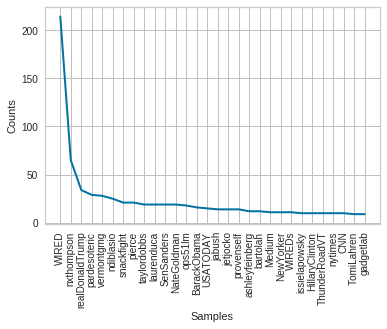

In [78]:
alex_ment, alex_tweets = get_mentions('AlexWhitcomb', 100)

In [80]:
alex_tweets

{'AlexWhitcomb': ["Let's just all take a second to remember that when Mark Zuckerberg first started Facebook, his business card read “… https://t.co/xZeLbB1l0J",
  "Pretty incredible: @McLarenF1 used to have the slowest tire changes in F1. Now they've record the fastest pit stop… https://t.co/yPh2LARsxO",
  '*spits up coffee* Uh, what? https://t.co/43WbwP2zvt',
  'A tale of two umbrellas. (Brilliance from @VanityFair) https://t.co/xHKgs7d97k',
  'Great read and point: "By releasing a genetic test, Elizabeth Warren has allowed herself to be dragged into a conve… https://t.co/gZP30GaCdw',
  "Ember's temperature regulating mug is actually amazing at keeping your coffee the perfect temperature. Even cooler:… https://t.co/TXXa0qKNsq",
  'That feeling when multiple people have recently complimented your work, and you remember that you’re also the guy w… https://t.co/XuQHVi3oGa',
  "-Yes Bing still exists.\n-Yes, apparently a significant percentage of the population still uses it. \n-Yes, it'

WIRED 3213


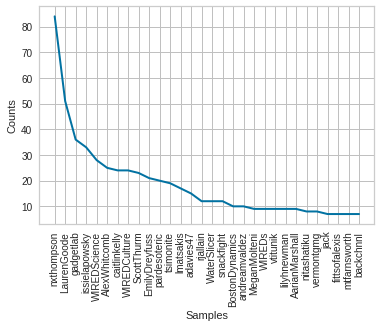

nxthompson 3238


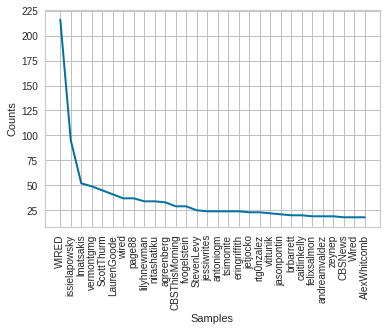

realDonaldTrump 3220


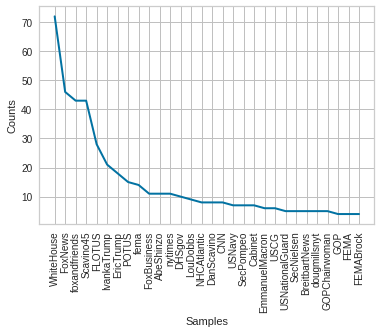

pardesoteric 334


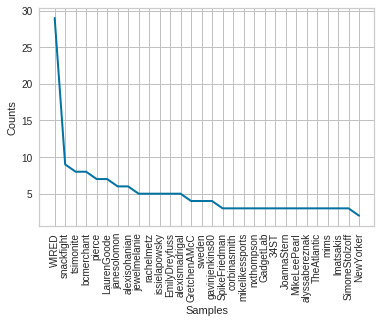

vermontgmg 3236


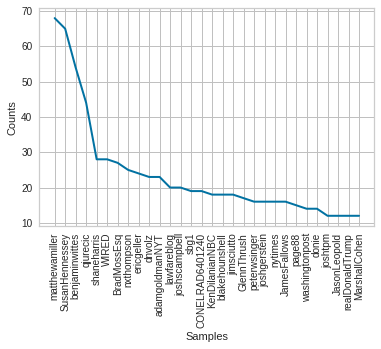

('ndiblasio', 25) Not authorized.
snackfight 3226


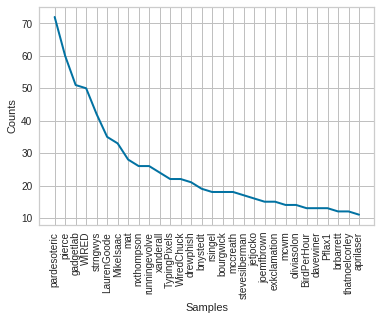

pierce 1245


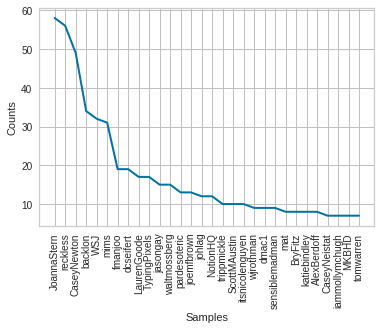

taylordobbs 3249


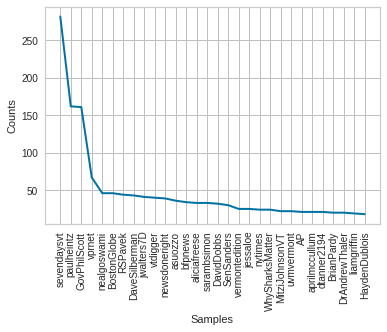

laurenduca 3224


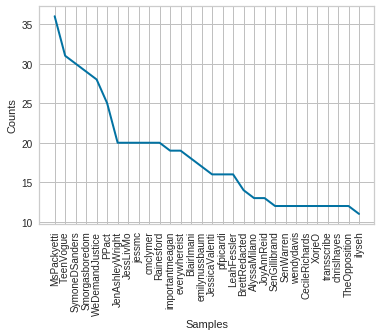

SenSanders 3220


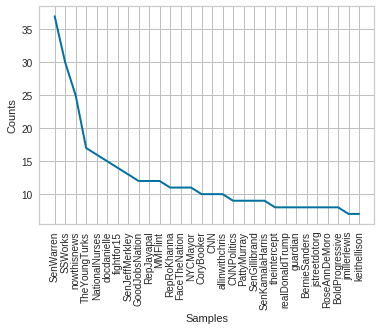

NateGoldman 3212


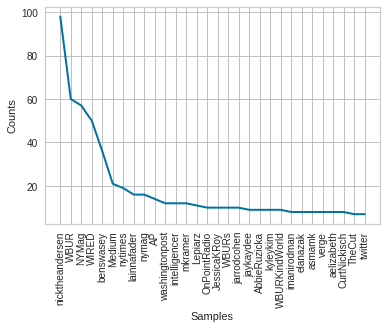

ops51lm 1198


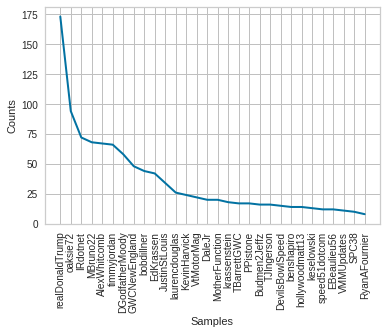

BarackObama 3229


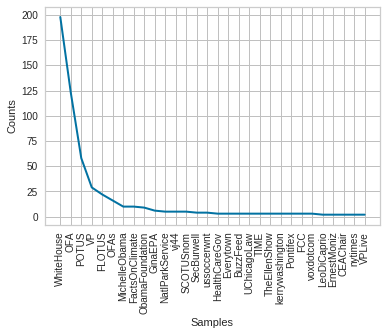

USATODAY 3249


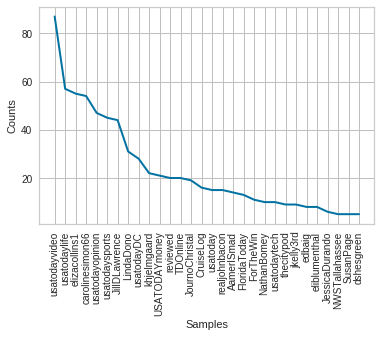

jabush 3201


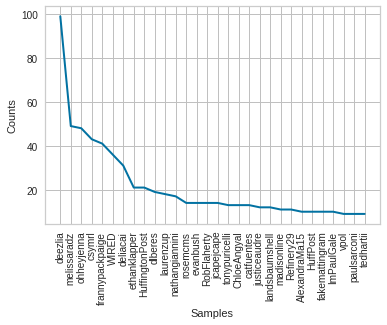

jetjocko 3230


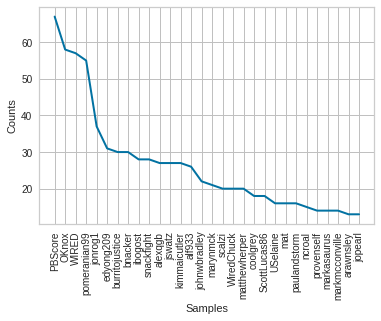

provenself 3212


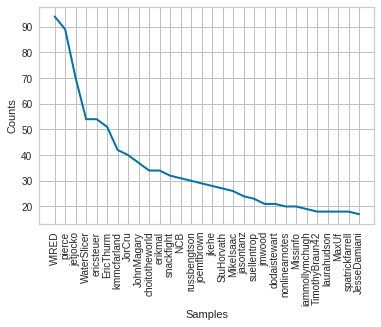

ashleyfeinberg 3220


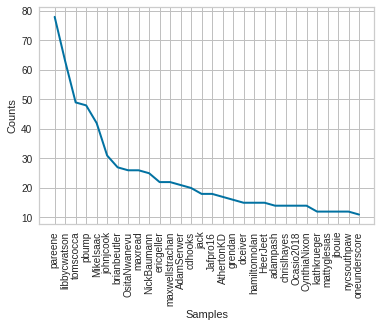

bartolah 3196


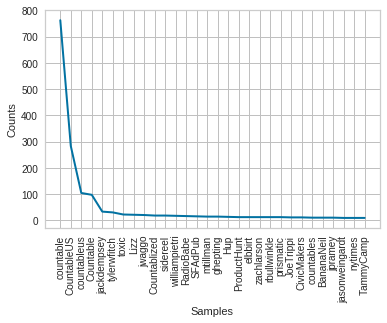

Medium 3210


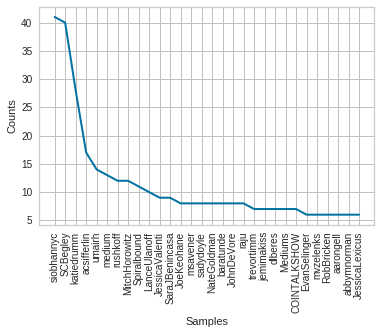

NewYorker 3246


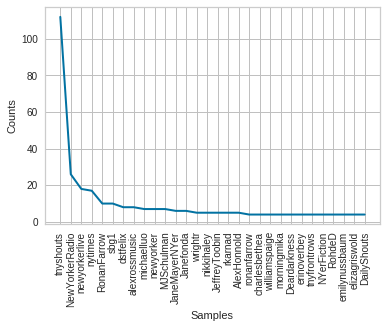

WIREDs 1


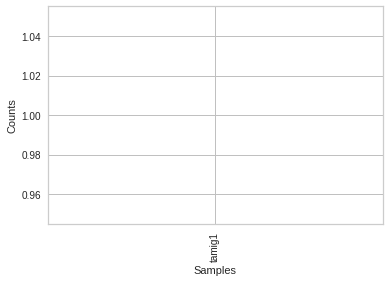

issielapowsky 3236


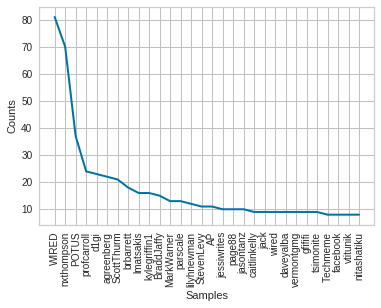

HillaryClinton 3235


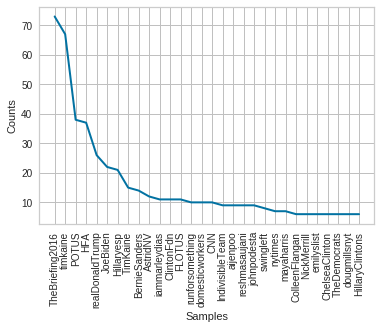

ThunderRoadVT 1104


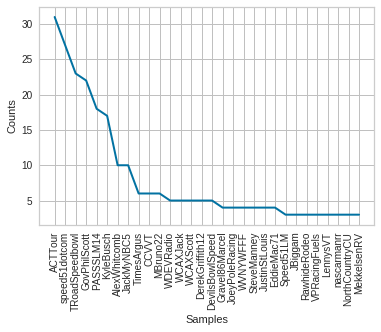

nytimes 3200


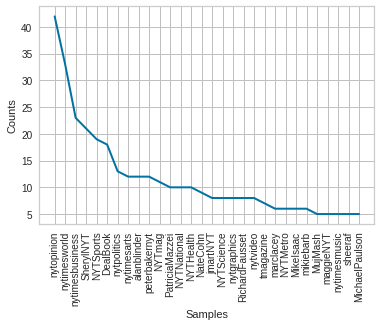

CNN 3228


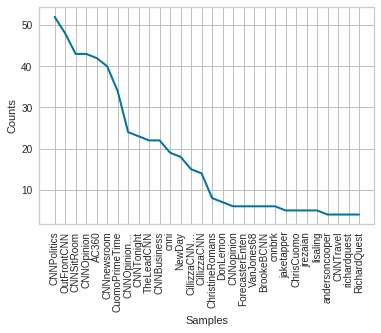

TomiLahren 3202


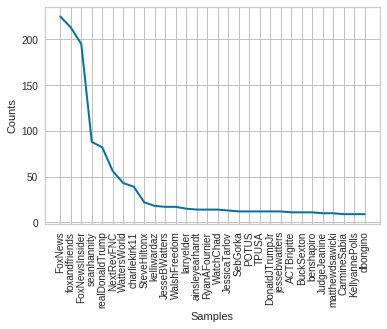

gadgetlab 3248


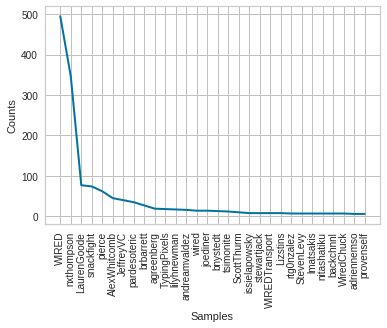

stewartjack 429


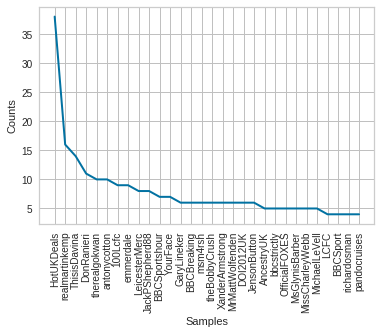

BrentSum 2166


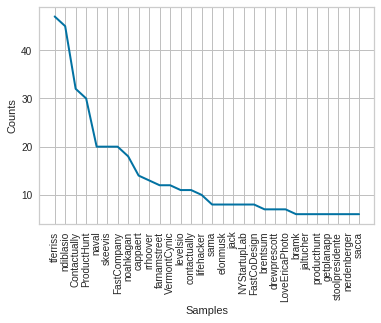

FoxNews 3202


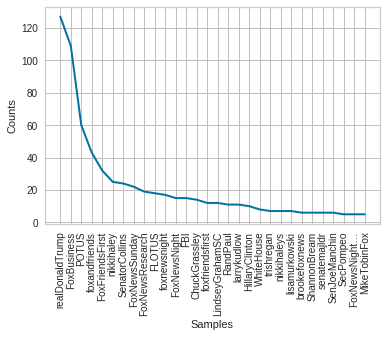

KinseyCrowley 125


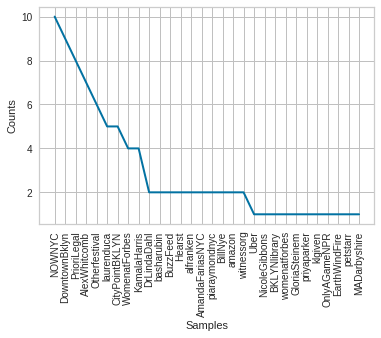

Melanieny5404 3189


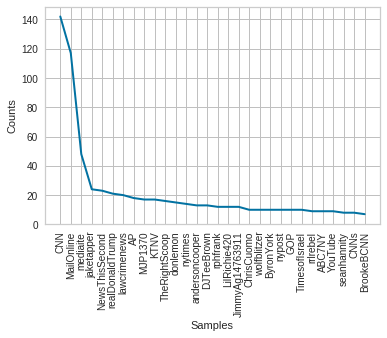

jessnthecity 3186


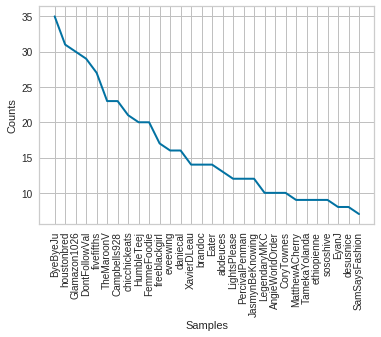

JoeBerkowitz 1479


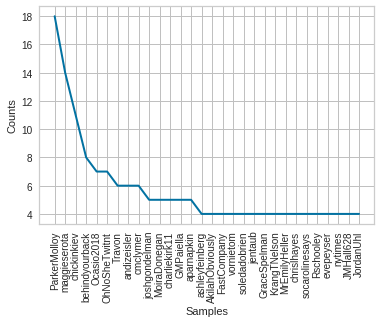

kylegriffin1 3248


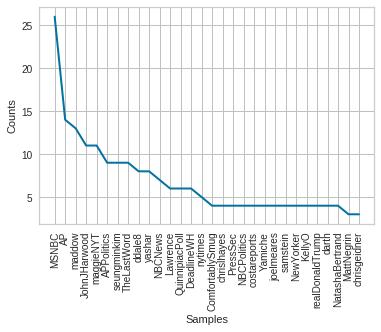

WiredChuck 3240


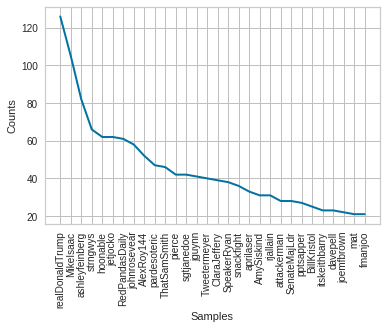

Trevornoah 3187


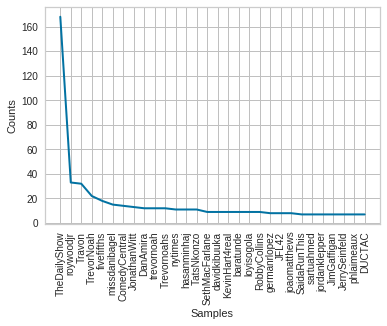

mtfarnsworth 3200


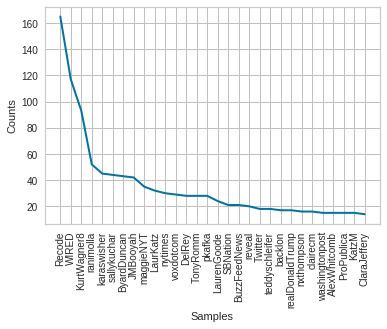

WIREDScience 3230


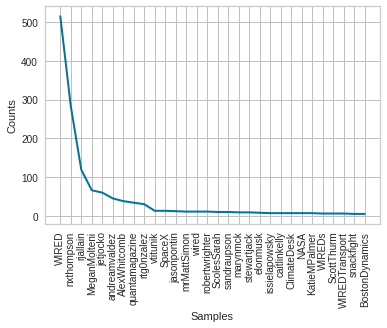

SenJohnMcCain 3221


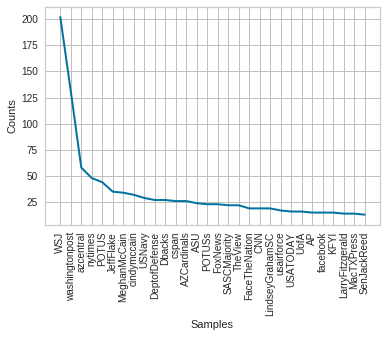

onstagevoice 3147


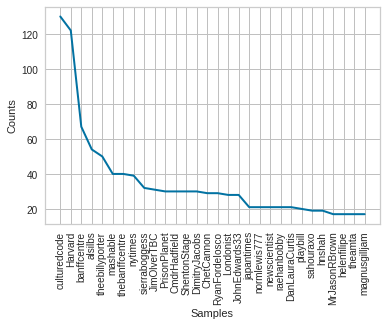

AMomentITL 393


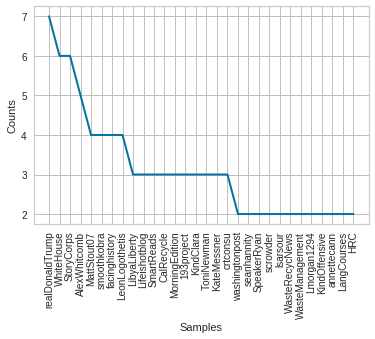

andreamvaldez 1819


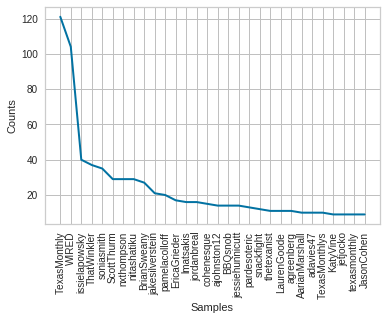

washingtonpost 3205


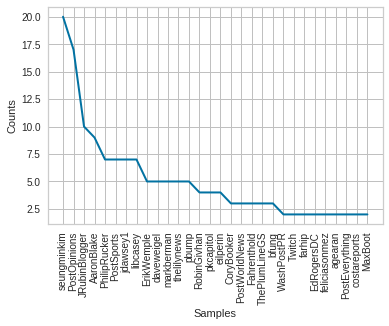

mrMattSimon 2393


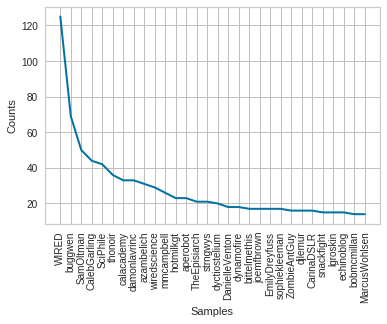

indumania 3184


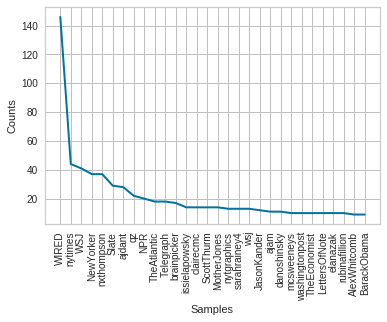

selenagomez 3198


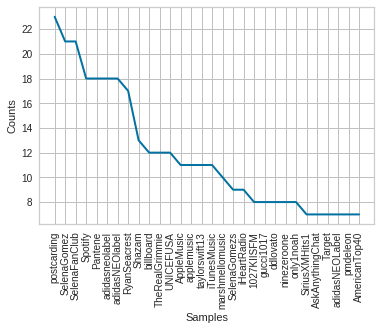

whyisjake 3225


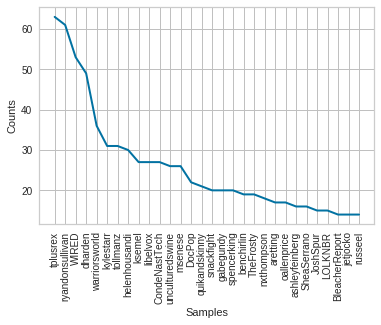

adavies47 3216


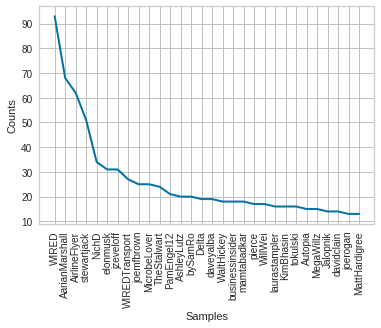

SenatorLeahy 3213


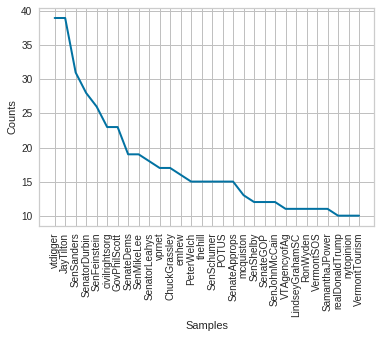

antoniogm 3215


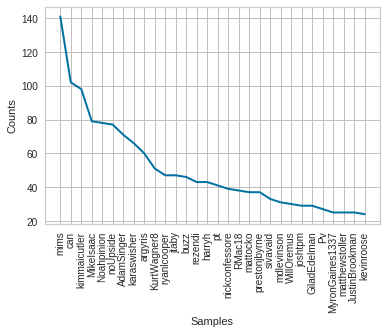

JohnMayer 2684


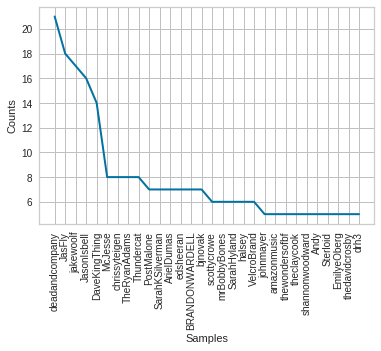

mabyillah 3237


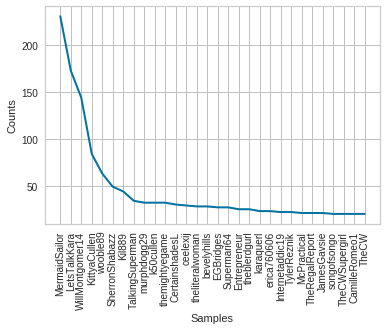

NASA 3214


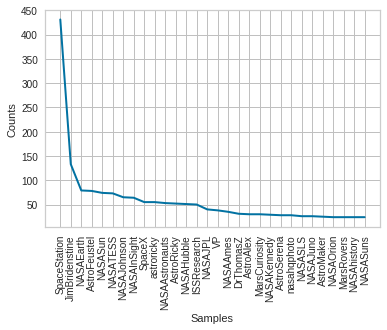

EmmaGreyEllis 272


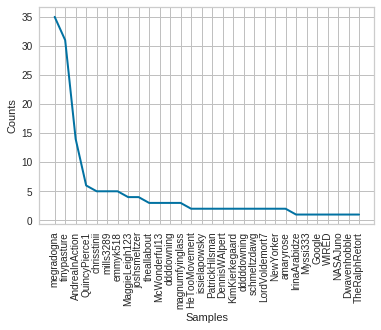

('DigitalSummits', 4) [{'message': 'Rate limit exceeded', 'code': 88}]
('Eagles', 4) [{'message': 'Rate limit exceeded', 'code': 88}]
('SpeakerRyan', 4) [{'message': 'Rate limit exceeded', 'code': 88}]
('elonmusk', 4) [{'message': 'Rate limit exceeded', 'code': 88}]
('AarianMarshall', 4) [{'message': 'Rate limit exceeded', 'code': 88}]
('JeffFlake', 4) [{'message': 'Rate limit exceeded', 'code': 88}]
('brbarrett', 4) [{'message': 'Rate limit exceeded', 'code': 88}]
('DavidDobbs', 4) [{'message': 'Rate limit exceeded', 'code': 88}]
('MikeyBlair', 4) [{'message': 'Rate limit exceeded', 'code': 88}]
('MelanieHannah', 4) [{'message': 'Rate limit exceeded', 'code': 88}]
('DebLynnSenger', 4) [{'message': 'Rate limit exceeded', 'code': 88}]
('iandavisian1', 4) [{'message': 'Rate limit exceeded', 'code': 88}]
('SuppressThis', 4) [{'message': 'Rate limit exceeded', 'code': 88}]
('OfficialSUtwit', 4) [{'message': 'Rate limit exceeded', 'code': 88}]
('tedcruz', 3) [{'message': 'Rate limit exceede

In [81]:
alex_net_dict, alex_tweets = network_and_tweets("AlexWhitcomb", alex_ment, 100)

In [82]:
len(alex_tweets)

57

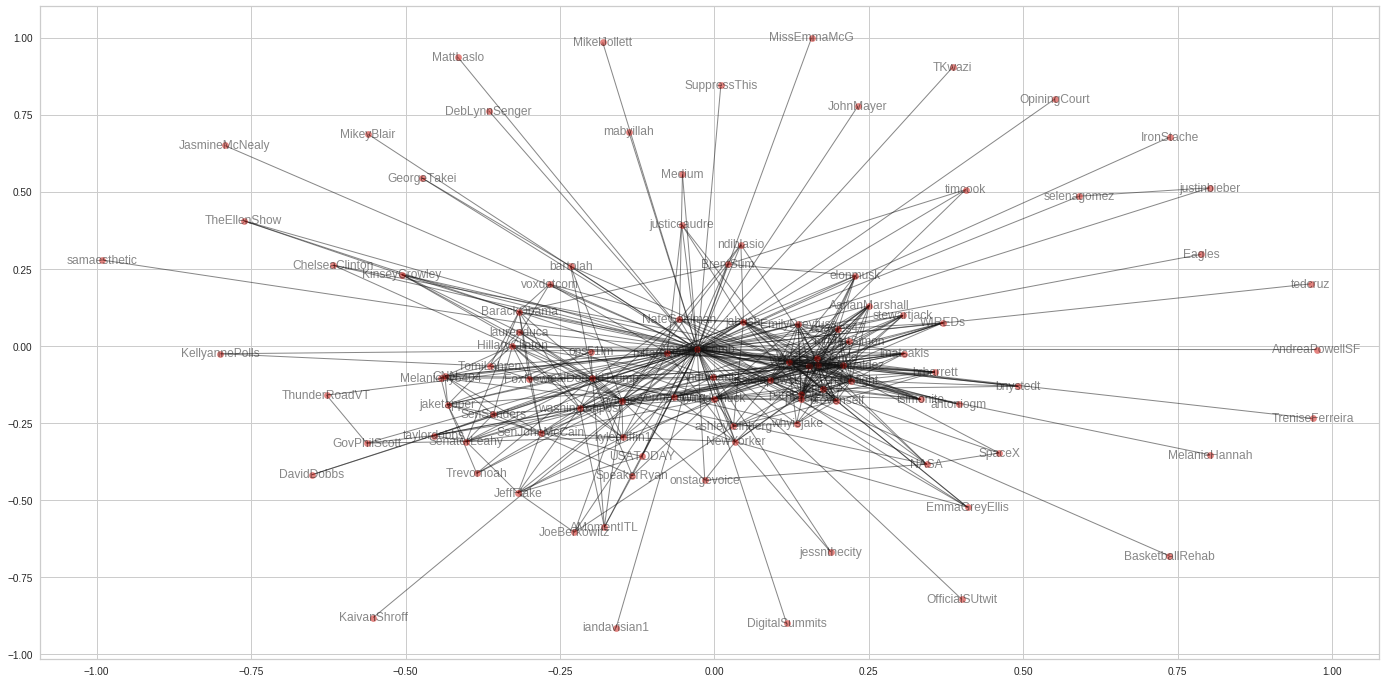

In [83]:
graph_network("AlexWhitcomb", alex_net_dict)

In [86]:
def make_tweets_list(tweets_dictionary):
    all_da_tweets = []
    for key in tweets_dictionary.keys():
        for sent in tweets_dictionary[key]:
            all_da_tweets.append(sent)
    return all_da_tweets
    

In [87]:
cv_alex = make_tweets_list(alex_tweets)

In [136]:
box_peeps = []
for name in alex_ment[:4]:
    box_peeps.append(name[0])
    

In [137]:
box_peeps

['WIRED', 'nxthompson', 'realDonaldTrump', 'pardesoteric']

In [142]:
new_list = []
for name in box_peeps:
    x = alex_tweets[name] 
    new_list.append(x)

In [163]:
newest_list = []
for x[0] in new_list[0]:
    newest_list.append(x[0])

In [164]:
len(newest_list)

3213

["Cable-cutters can't do much better than Roku's new Premiere Plus, which makes 4K streaming affordable for everyone https://t.co/7Wstq4dUax",
 'China’s APT1 group hacked over 100 US companies before getting exposed in 2013. It achieved instant infamy, and the… https://t.co/zcSN2WEVl8',
 'Warning: You may never trust lie detector tests ever again after reading this.  https://t.co/a0LjpCNMlY',
 "There are a lot of choices when it comes to Apple's MacBooks. Here's how to decide which one you should get. https://t.co/8npSG5tKKb",
 "Once nice thing about web-based services is that you rarely need to take charge. You just sign up and boom, you're… https://t.co/C9KQ4hw87u",
 "Sonos has a lot of options. Here's how to make sure you have the best audio set up for you and your home. https://t.co/BSTmRZPfxc",
 'The mug that keeps your drink at your preferred temperature—and not a degree cooler—just got a little better https://t.co/dJ53kA1kN1',
 'This is a look at life in Donbass, the region of e

In [145]:
tsne_vis(newest_list, box_peeps)

AttributeError: 'list' object has no attribute 'lower'

In [144]:
# Graphing tool for t-SNE
def tsne_vis(corpus, classesw):
    tfidf  = TfidfVectorizer()
    tsne = TSNEVisualizer(classes=classesw)
    docs   = tfidf.fit_transform(corpus)
    # Create the visualizer and draw the vectors
    tsne.fit(docs)
    tsne.poof()

In [166]:
for user in alex_ment[:4]:   
    try:
        tsne_vis(alex_tweets[user[0]])
        print(user[0])
        #handle exception and return the error and username
    except Exception as e:
        print(user, e)


('WIRED', 214) tsne_vis() missing 1 required positional argument: 'classesw'
('nxthompson', 65) tsne_vis() missing 1 required positional argument: 'classesw'
('realDonaldTrump', 34) tsne_vis() missing 1 required positional argument: 'classesw'
('pardesoteric', 29) tsne_vis() missing 1 required positional argument: 'classesw'


In [124]:
tsne_vis(cv_alex)

KeyboardInterrupt: 

In [56]:
len(alex_tweets["AlexWhitcomb"])

3175

In [91]:
def make_tweets_list(tweets_dictionary):
    all_da_tweets = []
    for key in tweets_dictionary.keys():
        for sent in tweets_dictionary[key]:
            all_da_tweets.append(sent)
    return all_da_tweets
    

In [92]:
cv_alex = make_tweets_list(alex_tweets)

In [94]:
my_additional_stop_words = ['http', 'https', 'rt', 'amp', 'drdisrespect']
stop_words = text.ENGLISH_STOP_WORDS.union(my_additional_stop_words)

In [95]:
n_features= 2000



tf_vectorizer = CountVectorizer(max_df=0.95, min_df=4,
                            max_features=n_features,
                            stop_words=stop_words)
tf = tf_vectorizer.fit_transform(cv_alex)


In [97]:
tf.getnnz()

733452

In [98]:
tf_feature_names = tf_vectorizer.get_feature_names()

In [99]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

LDA pipeline

In [117]:
pipeline = Pipeline([
    ('vect',          CountVectorizer(max_df=0.95, 
                                      min_df=2,
                                      max_features=n_features,
                                      stop_words=stop_words)),
    
    ('tfidf',         TfidfVectorizer(max_df=0.95, 
                                      min_df=2,
                                      max_features=n_features,
                                      stop_words=stop_words)),
    
    ('clf', LatentDirichletAllocation(batch_size=batch, 
                                      doc_topic_prior=None,
                                      evaluate_every=-1, 
                                      learning_decay=1,
                                      learning_method='batch', 
                                      learning_offset=lo,
                                      max_doc_update_iter=100, 
                                      max_iter=10, 
                                      mean_change_tol=0.001,
                                      n_components=nc,
                                      n_jobs=8, 
                                      n_topics=None,
                                      perp_tol=0.1,
                                      random_state=0, 
                                      topic_word_prior=None,
                                      total_samples=ts, 
                                      verbose=0))
                ])

In [ ]:
parameters = {
    'vect__max_df': (0.5, 0.75, 1.0),
    # 'vect__max_features': (None, 5000, 10000, 50000),
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    # 'tfidf__use_idf': (True, False),
    # 'tfidf__norm': ('l1', 'l2'),
    'clf__max_iter': (5,),
    'clf__alpha': (0.00001, 0.000001),
    'clf__penalty': ('l2', 'elasticnet'),
    # 'clf__max_iter': (10, 50, 80),
}

Pipeline(memory=None,
     steps=[('tfidfvectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_i..., perp_tol=0.1, random_state=0,
             topic_word_prior=None, total_samples=4000, verbose=0))])

In [115]:
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=n_features,
                                stop_words=stop_words)),
    ('lda', LatentDirichletAllocation(batch_size=batch, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=1,
             learning_method='batch', learning_offset=lo,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=nc, n_jobs=8, n_topics=None, perp_tol=0.1,
             random_state=0, topic_word_prior=None,
             total_samples=ts, verbose=0))
                ])

NameError: name 'Pipeline' is not defined

In [103]:
#batch_siz
batch = 2000
#n_components
nc = 20
#total_samples
ts = 4000
#learning_offset
lo = 50
n_top_words = 20


lda = LatentDirichletAllocation(batch_size=batch, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=1,
             learning_method='batch', learning_offset=lo,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=nc, n_jobs=8, n_topics=None, perp_tol=0.1,
             random_state=0, topic_word_prior=None,
             total_samples=ts, verbose=0)
# def lda_k_search(vect_corpus, k):
    
lda.fit(tf)
print_top_words(lda, tf_feature_names, n_top_words)

Topic #0: way twitter 000 apple police long weekend heard 10 20 iphone new 100 ve shot dead baby killed statement opening
Topic #1: year old new today lol public gun space john black launch months service gt different congress air washington mccain comes
Topic #2: work yes real come bad looking like hard morning good feel little needs watching miss writes forward self saudi reason
Topic #3: just want know best google country thought photo don like thinking movie wanted mueller song hours folks saw search posted
Topic #4: like love thank got using game looks money city talking look ve nice shows play easy leahy guys works incredible
Topic #5: health care happy home job used true million amazon pay room plan billion birthday tomorrow workers americans paid inside town
Topic #6: better media read social tax business death open new nytimes security try hate 2017 bring stories san sorry protect study
Topic #7: going thing did sure tweet week book away hey hear run internet trying make recor

In [ ]:
import graphlab as gl
import pandas as pd
import pyLDAvis
import pyLDAvis.graphlab

pyLDAvis.enable_notebook()

In [122]:
import pyLDAvis
import pyLDAvis.gensim

corpus = [
    gensim_lda.model.named_steps['vect'].lexicon.doc2bow(doc)
    for doc in gensim_lda.model.named_steps['norm'].transform 
]

#batch_siz
batch = 2000
#n_components
nc = 10
#total_samples
ts = 4000
#learning_offset
lo = 50
n_top_words = 20

lda = LatentDirichletAllocation(batch_size=batch, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=1,
             learning_method='batch', learning_offset=lo,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=nc, n_jobs=8, n_topics=None, perp_tol=0.1,
             random_state=0, topic_word_prior=None,
             total_samples=ts, verbose=0)

In [104]:
#batch_siz
batch = 2000
#n_components
nc = 10
#total_samples
ts = 4000
#learning_offset
lo = 50
n_top_words = 20


lda = LatentDirichletAllocation(batch_size=batch, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=1,
             learning_method='batch', learning_offset=lo,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=nc, n_jobs=8, n_topics=None, perp_tol=0.1,
             random_state=0, topic_word_prior=None,
             total_samples=ts, verbose=0)
# def lda_k_search(vect_corpus, k):
    
lda.fit(tf)
print_top_words(lda, tf_feature_names, n_top_words)

Topic #0: president obama way watch live america hillary ford realdonaldtrump apple great hearing ve win police today north weekend clinton wired
Topic #1: new time today thanks space lol year york public gun black john launch sexual times earth 000 service gt congress
Topic #2: like good work yes people just bad looking hard little time feel story real look come looks car actually thing
Topic #3: just day want ll years best year google old man 10 ago country today ve left wired photo thought star
Topic #4: love thank got media countable social thanks city money app facebook new tonight kind great video shows leahy stop ve
Topic #5: right night health care happy million twitter day true tomorrow home road amazon today season open read late russian live
Topic #6: read court change better world people supreme states women high united help trump climate children men new fight school human
Topic #7: wired going make news sure week nxthompson new tweet book thing story hey hear party intern

In [105]:
#batch_siz
batch = 2000
#n_components
nc = 30
#total_samples
ts = 4000
#learning_offset
lo = 50
n_top_words = 20


lda = LatentDirichletAllocation(batch_size=batch, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=1,
             learning_method='batch', learning_offset=lo,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=nc, n_jobs=8, n_topics=None, perp_tol=0.1,
             random_state=0, topic_word_prior=None,
             total_samples=ts, verbose=0)
# def lda_k_search(vect_corpus, k):
    
lda.fit(tf)
print_top_words(lda, tf_feature_names, n_top_words)

Topic #0: twitter 000 apple morning weekend air iphone 20 100 military works shot tour baby jetjocko address snackfight sevendaysvt happens percent
Topic #1: year old black lol space woman gt gun different months proud super past companies literally sanders action safe violence fall
Topic #2: like work yes real bad feel john looks guy needs writes reason people mccain tv making does feels worse journalists
Topic #3: just best country google photo watching fb hours movie guys 15 search folks truly moving enjoy posted area learning jobs
Topic #4: hurricane michael using talking support leahy florida city service play hate incredible senatorleahy senator statement money ed la reality vt
Topic #5: night 10 million home used set open russian amazon tomorrow friday running inside late billion issielapowsky worst town happen 30
Topic #6: read business death pay young try yeah 2017 bring san started hold parents summer message crime russia dog brain turned
Topic #7: week book questions hey hea

In [110]:
#batch_siz
batch = 2000
#n_components
nc = 20
#total_samples
ts = 4000
#learning_offset
lo = 80
n_top_words = 20


lda = LatentDirichletAllocation(batch_size=batch, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=1,
             learning_method='batch', learning_offset=lo,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=nc, n_jobs=8, n_topics=None, perp_tol=0.1,
             random_state=0, topic_word_prior=None,
             total_samples=ts, verbose=0)
# def lda_k_search(vect_corpus, k):
    
lda.fit(tf)
print_top_words(lda, tf_feature_names, n_top_words)

Topic #0: way twitter 000 apple police long weekend heard 10 20 iphone new 100 ve shot dead baby killed statement opening
Topic #1: year old new today lol public gun space john black launch months service gt different congress air washington mccain comes
Topic #2: work yes real come bad looking like hard morning good feel little needs watching miss writes forward self saudi reason
Topic #3: just want know best google country thought photo don like thinking movie wanted mueller song hours folks saw search posted
Topic #4: like love thank got using game looks money city talking look ve nice shows play easy leahy guys works incredible
Topic #5: health care happy home job used true million amazon pay room plan billion birthday tomorrow workers americans paid inside town
Topic #6: better media read social tax business death open new nytimes security try hate 2017 bring stories san sorry protect study
Topic #7: going thing did sure tweet week book away hey hear run internet trying make recor

In [108]:
#batch_siz
batch = 2000
#n_components
nc = 30
#total_samples
ts = 4000
#learning_offset
lo = 50
n_top_words = 20


lda = LatentDirichletAllocation(batch_size=batch, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=1,
             learning_method='batch', learning_offset=lo,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=nc, n_jobs=8, n_topics=None, perp_tol=0.1,
             random_state=0, topic_word_prior=None,
             total_samples=ts, verbose=0)
# def lda_k_search(vect_corpus, k):
    
lda.fit(tf)
print_top_words(lda, tf_feature_names, n_top_words)

Topic #0: twitter 000 apple morning weekend air iphone 20 100 military works shot tour baby jetjocko address snackfight sevendaysvt happens percent
Topic #1: year old black lol space woman gt gun different months proud super past companies literally sanders action safe violence fall
Topic #2: like work yes real bad feel john looks guy needs writes reason people mccain tv making does feels worse journalists
Topic #3: just best country google photo watching fb hours movie guys 15 search folks truly moving enjoy posted area learning jobs
Topic #4: hurricane michael using talking support leahy florida city service play hate incredible senatorleahy senator statement money ed la reality vt
Topic #5: night 10 million home used set open russian amazon tomorrow friday running inside late billion issielapowsky worst town happen 30
Topic #6: read business death pay young try yeah 2017 bring san started hold parents summer message crime russia dog brain turned
Topic #7: week book questions hey hea

In [109]:
#batch_siz
batch = 5000
#n_components
nc = 20
#total_samples
ts = 4000
#learning_offset
lo = 50
n_top_words = 20


lda = LatentDirichletAllocation(batch_size=batch, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=1,
             learning_method='batch', learning_offset=lo,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=nc, n_jobs=8, n_topics=None, perp_tol=0.1,
             random_state=0, topic_word_prior=None,
             total_samples=ts, verbose=0)
# def lda_k_search(vect_corpus, k):
    
lda.fit(tf)
print_top_words(lda, tf_feature_names, n_top_words)

Topic #0: way twitter 000 apple police long weekend heard 10 20 iphone new 100 ve shot dead baby killed statement opening
Topic #1: year old new today lol public gun space john black launch months service gt different congress air washington mccain comes
Topic #2: work yes real come bad looking like hard morning good feel little needs watching miss writes forward self saudi reason
Topic #3: just want know best google country thought photo don like thinking movie wanted mueller song hours folks saw search posted
Topic #4: like love thank got using game looks money city talking look ve nice shows play easy leahy guys works incredible
Topic #5: health care happy home job used true million amazon pay room plan billion birthday tomorrow workers americans paid inside town
Topic #6: better media read social tax business death open new nytimes security try hate 2017 bring stories san sorry protect study
Topic #7: going thing did sure tweet week book away hey hear run internet trying make recor

YellowbrickTypeError: The supplied model is not a clustering estimator; try a classifier or regression score visualizer instead!

In [ ]:
d

In [ ]:
tsne_vis(cv_alex)

In [ ]:
# Create the visualizer and draw the vectors
tsne = TSNEVisualizer()
tsne.fit(docs)
tsne.poof()

In [ ]:
from sklearn.feature_extraction import text 
my_additional_stop_words = ['http', 'https', 'rt', 'amp', 'drdisrespect']
stop_words = text.ENGLISH_STOP_WORDS.union(my_additional_stop_words)

from __future__ import print_function
from time import time


from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

n_samples = 2000
n_features = 3000
n_components = 20
n_top_words = 20
learning_method = 'batch'


def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

print("Loading dataset...")
t0 = time()
# dataset = 
data_samples = all_da_tweets
print("done in %0.3fs." % (time() - t0))

print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=n_features,
                                stop_words=stop_words)
t0 = time()
tf = tf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))
print()

# Fit the NMF model
print("Fitting the NMF model (Frobenius norm) with tf-idf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
t0 = time()
nmf = NMF(n_components=n_components, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in NMF model (Frobenius norm):")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

# Fit the NMF model
print("Fitting the NMF model (generalized Kullback-Leibler divergence) with "
      "tf-idf features, n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
t0 = time()
nmf = NMF(n_components=n_components, random_state=1,
          beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1,
          l1_ratio=.5).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in NMF model (generalized Kullback-Leibler divergence):")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

print("Fitting LDA models with tf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
lda = LatentDirichletAllocation(batch_size=2000, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=1,
             learning_method='batch', learning_offset=55.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=n_components, n_jobs=1, n_topics=None, perp_tol=0.1,
             random_state=0, topic_word_prior=None,
             total_samples=100000.0, verbose=0)

    
t0 = time()
lda.fit(tf)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in LDA model:")
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)